In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/MECD/2º\ ano/Tese/Implementação

In [2]:
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended texlive-latex-recommended cm-super

done.


In [3]:
!pip install SciencePlots

In [4]:
import numpy as np
import pandas as pd

from sklearn.feature_selection import mutual_info_regression, r_regression, f_regression

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")
import seaborn as sns

In [5]:
def load_data(dataset_path, test=False, index_col=[]):
  train = pd.read_csv(f"{dataset_path}/train.csv", index_col=index_col)
  val = pd.read_csv(f"{dataset_path}/val.csv")

  if not test: # if the test set isn't needed
    return train.iloc[:, :-1], train.iloc[:, -1], \
            val.iloc[:, :-1], val.iloc[:, -1]

  test = pd.read_csv(f"{dataset_path}/test.csv")

  return train.iloc[:, :-1], train.iloc[:, -1], \
          val.iloc[:, :-1], val.iloc[:, -1], \
          test.iloc[:, :-1], test.iloc[:, -1]

In [6]:
def eval_input(model: KNeighborsRegressor, train_X, train_y, val_X, val_y,
               input_name,
               mae_by_time=True, pred_timespan=48,
               labels: np.array = np.array(["0-8", "8-16", "16-24", "24-32", "32-40", "40-48"])):

  if type(train_X) == pd.DataFrame:
    train_X = train_X.values
    train_y = train_y.values
    val_X = val_X.values
    val_y = val_y.values

  model = model.fit(train_X, train_y)
  preds = model.predict(val_X)

  mape = mean_absolute_percentage_error(val_y, preds)
  mae = mean_absolute_error(val_y, preds)
  rmse = mean_squared_error(val_y, preds, squared=False)
  r2 = r2_score(val_y, preds)

  metrics_df = pd.DataFrame(data=[[mape, mae, rmse, r2]],
                            columns=["MAPE", "MAE", "RMSE", "R2"],
                            index=[input_name])

  if not mae_by_time: # if we only want the overall metrics
    return metrics_df

  n_bins = len(labels)
  time_bins = np.arange(pred_timespan+n_bins, step=pred_timespan/n_bins)
  time_bins_labels = labels[np.digitize(val_y/60, time_bins)-1]

  preds_series = pd.Series(data=preds, name="predictions")
  targets_series = pd.Series(data=val_y, name="targets")
  rtt_bins_series = pd.Series(data=time_bins_labels, name="Remaining Travel Time (minutes)")

  mae_by_time_df = pd.concat((preds_series, targets_series, rtt_bins_series), axis=1)\
                        .groupby("Remaining Travel Time (minutes)", group_keys=False)\
                        .apply(lambda x: mean_absolute_error(x["targets"], x["predictions"]))


  return metrics_df, mae_by_time_df

# Feature Ranking

In [ ]:
train_X, train_y, val_X, val_y = load_data("final_miami_datasets/no_history", test=False, index_col=[0,1])

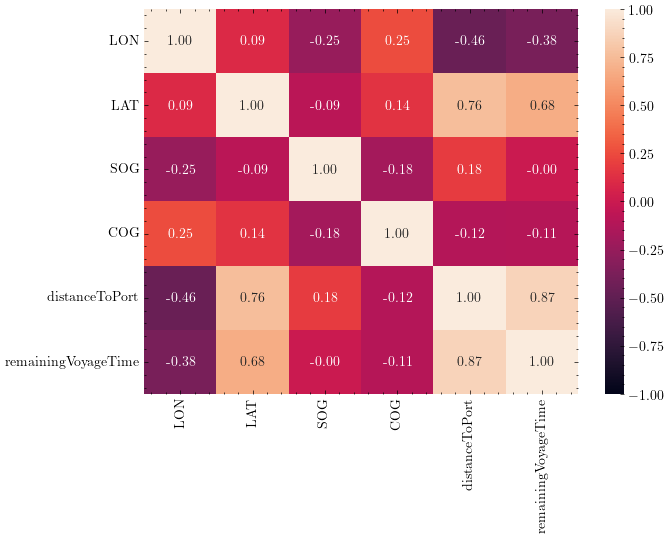

In [ ]:
plt.figure(figsize=(7,5))
sns.heatmap(pd.concat((train_X, train_y), axis=1).corr(), annot=True, vmin=-1, vmax=1, fmt=".2f")
plt.savefig("figures/InputTesting/feats_corr")
plt.show()

In [ ]:
feats = np.array(train_X.columns)

In [ ]:
train_X = train_X.values
train_y = train_y.values
val_X = val_X.values
val_y = val_y.values

In [ ]:
train_X_standard = StandardScaler().fit_transform(train_X)

In [ ]:
mutual_info = mutual_info_regression(train_X_standard, train_y, discrete_features=False, random_state=1)

In [ ]:
mutual_info = pd.Series(data=mutual_info, name="Mutual Information")
mutual_info.sort_values(ascending=False, inplace=True)
feats_mutual_info = pd.concat((mutual_info, pd.Series(feats[mutual_info.index], index=mutual_info.index, name="Variable")), axis=1)

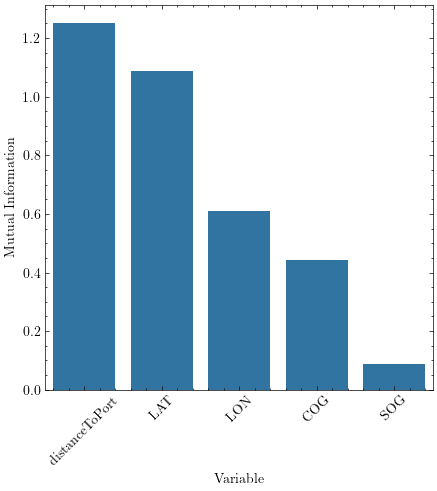

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
sns.barplot(data=feats_mutual_info, x="Variable", y="Mutual Information", color="tab:blue", ax=ax)
plt.xticks(rotation=45)
plt.savefig("feats_mutual_info")
plt.show()

TypeError: ignored

<Figure size 500x500 with 0 Axes>

In [ ]:
f_stats, p_values = f_regression(train_X_standard, train_y)

In [ ]:
f_stats = pd.Series(data=f_stats, name="F-Statistic")
p_values = pd.Series(data=p_values, name="P-Value")

f_stats.sort_values(ascending=False, inplace=True)
p_values.sort_values(ascending=False, inplace=True)

In [ ]:
feats_f_stats = pd.concat((f_stats, pd.Series(feats[f_stats.index], index=f_stats.index, name="Variable")), axis=1)
feats_p_values = pd.concat((p_values, pd.Series(feats[p_values.index], index=p_values.index, name="Variable")), axis=1)

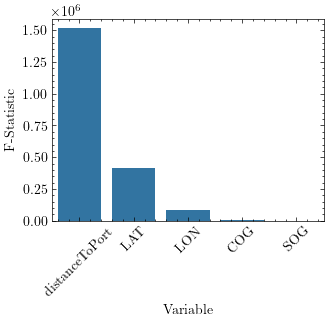

In [ ]:
fig, ax = plt.subplots()
sns.barplot(data=feats_f_stats, x="Variable", y="F-Statistic", color="tab:blue", ax=ax)
plt.xticks(rotation=45)
plt.savefig("feats_f_stats")
plt.show()

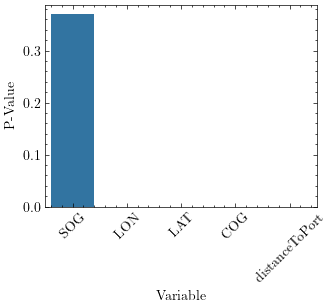

In [ ]:
fig, ax = plt.subplots()
sns.barplot(data=feats_p_values, x="Variable", y="P-Value", color="tab:blue", ax=ax)
plt.xticks(rotation=45)
plt.savefig("feats_p_values")
plt.show()

# Testing with increasing no. of ranked features (KNN)

In [ ]:
# Testar por ordem de mutual info
train_X = train_X[:, mutual_info.index]
val_X = val_X[:, mutual_info.index]

In [ ]:
knr = KNeighborsRegressor(n_neighbors=500, weights="distance", p=2)
ss_knr = Pipeline([("ss", StandardScaler()), ("knr", KNeighborsRegressor(n_neighbors=500, weights="distance", p=2))])

In [ ]:
metrics_df_final = pd.DataFrame(columns=["MAPE", "MAE", "RMSE", "R2"])
metrics_df_ss_final = pd.DataFrame(columns=["MAPE", "MAE", "RMSE", "R2"])
mae_by_time_df_final = []
mae_by_time_df_ss_final = []
for i in range(1,6):
  input_train_X = train_X[:, :i]
  input_val_X = val_X[:, :i]

  metrics_df = eval_input(knr, input_train_X, train_y, input_val_X, val_y, input_name=str(i), mae_by_time=False)

  metrics_df_ss = eval_input(ss_knr, input_train_X, train_y, input_val_X, val_y, input_name=str(i), mae_by_time=False)

  metrics_df_final = pd.concat((metrics_df_final, metrics_df), axis=0)
  metrics_df_ss_final = pd.concat((metrics_df_ss_final, metrics_df_ss), axis=0)

In [ ]:
display(metrics_df_final)
display(metrics_df_ss_final)

,MAPE,MAE,RMSE,R2
1,0.360027,236.337701,331.602470,0.725956
2,0.328845,210.724368,294.951322,0.783187
3,0.329188,209.144381,292.113494,0.787339
4,0.323333,208.478343,296.093747,0.781504
5,0.266199,178.414397,269.940468,0.818398


,MAPE,MAE,RMSE,R2
1,0.360027,236.337701,331.602470,0.725956
2,0.324432,207.506791,290.947290,0.789034
3,0.325071,207.795488,293.332189,0.785561
4,0.299353,199.860937,286.405338,0.795569
5,0.263105,168.710174,258.808813,0.833067


In [ ]:
print(metrics_df_final.style.to_latex())
print(metrics_df_ss_final.style.to_latex())

\begin{tabular}{lrrrr}
 & MAPE & MAE & RMSE & R2 \\
1 & 0.360027 & 236.337701 & 331.602470 & 0.725956 \\
2 & 0.328845 & 210.724368 & 294.951322 & 0.783187 \\
3 & 0.329188 & 209.144381 & 292.113494 & 0.787339 \\
4 & 0.323333 & 208.478343 & 296.093747 & 0.781504 \\
5 & 0.266199 & 178.414397 & 269.940468 & 0.818398 \\
\end{tabular}

\begin{tabular}{lrrrr}
 & MAPE & MAE & RMSE & R2 \\
1 & 0.360027 & 236.337701 & 331.602470 & 0.725956 \\
2 & 0.324432 & 207.506791 & 290.947290 & 0.789034 \\
3 & 0.325071 & 207.795488 & 293.332189 & 0.785561 \\
4 & 0.299353 & 199.860937 & 286.405338 & 0.795569 \\
5 & 0.263105 & 168.710174 & 258.808813 & 0.833067 \\
\end{tabular}



- Best results with the 5 features normalized.

# Testing with chosen features for all original and filled train sets (KNN)

In [ ]:
train_X, train_y, val_X, val_y = load_data("final_miami_datasets/no_history", test=False)
train_10min_X, train_10min_y, val_10min_X, val_10min_y = load_data("final_miami_datasets/10min_history", test=False)
train_20min_X, train_20min_y, val_20min_X, val_20min_y = load_data("final_miami_datasets/20min_history", test=False)
train_30min_X, train_30min_y, val_30min_X, val_30min_y = load_data("final_miami_datasets/30min_history", test=False)

train_filled_X, train_filled_y, _, _ = load_data("final_miami_datasets/no_history_filled", test=False)
train_10min_filled_X, train_10min_filled_y, _, _ = load_data("final_miami_datasets/10min_history_filled", test=False)
train_20min_filled_X, train_20min_filled_y, _, _ = load_data("final_miami_datasets/20min_history_filled", test=False)
train_30min_filled_X, train_30min_filled_y, _, _ = load_data("final_miami_datasets/30min_history_filled", test=False)

In [ ]:
knr_pipe = Pipeline([("ss", StandardScaler()), ("knr", KNeighborsRegressor(n_neighbors=500, weights="distance", p=2, n_jobs=-1))])

In [ ]:
metrics_df_hist_final = pd.DataFrame(columns=["MAPE", "MAE", "RMSE", "R2"])
metrics_df_hist_filled_final = pd.DataFrame(columns=["MAPE", "MAE", "RMSE", "R2"])

In [ ]:
metrics_df_hist = eval_input(knr_pipe, train_X, train_y, val_X, val_y, input_name="No History", mae_by_time=False)
metrics_df_hist_filled = eval_input(knr_pipe, train_filled_X, train_filled_y, val_X, val_y,
                                    input_name="No History Filled", mae_by_time=False)

metrics_df_hist_final = pd.concat((metrics_df_hist_final, metrics_df_hist), axis=0)
metrics_df_hist_filled_final = pd.concat((metrics_df_hist_filled_final, metrics_df_hist_filled), axis=0)

In [ ]:
metrics_df_hist = eval_input(knr_pipe, train_10min_X, train_10min_y, val_10min_X, val_10min_y,
                             input_name="10 Minutes", mae_by_time=False)
metrics_df_hist_filled = eval_input(knr_pipe, train_10min_filled_X, train_10min_filled_y, val_10min_X, val_10min_y,
                                    input_name="10 Minutes Filled", mae_by_time=False)

metrics_df_hist_final = pd.concat((metrics_df_hist_final, metrics_df_hist), axis=0)
metrics_df_hist_filled_final = pd.concat((metrics_df_hist_filled_final, metrics_df_hist_filled), axis=0)

In [ ]:
metrics_df_hist = eval_input(knr_pipe, train_20min_X, train_20min_y, val_20min_X, val_20min_y,
                             input_name="20 Minutes", mae_by_time=False)
metrics_df_hist_filled = eval_input(knr_pipe, train_20min_filled_X, train_20min_filled_y, val_20min_X, val_20min_y,
                                    input_name="20 Minutes Filled", mae_by_time=False)

metrics_df_hist_final = pd.concat((metrics_df_hist_final, metrics_df_hist), axis=0)
metrics_df_hist_filled_final = pd.concat((metrics_df_hist_filled_final, metrics_df_hist_filled), axis=0)

In [ ]:
metrics_df_hist = eval_input(knr_pipe, train_30min_X, train_30min_y, val_30min_X, val_30min_y,
                             input_name="30 Minutes", mae_by_time=False)
metrics_df_hist_filled = eval_input(knr_pipe, train_30min_filled_X, train_30min_filled_y, val_30min_X, val_30min_y,
                                    input_name="30 Minutes Filled", mae_by_time=False)

metrics_df_hist_final = pd.concat((metrics_df_hist_final, metrics_df_hist), axis=0)
metrics_df_hist_filled_final = pd.concat((metrics_df_hist_filled_final, metrics_df_hist_filled), axis=0)

In [ ]:
display(metrics_df_hist_final)
display(metrics_df_hist_filled_final)

,MAPE,MAE,RMSE,R2
No History,0.263105,168.710174,258.808813,0.833067
10 Minutes,0.294307,169.432936,258.327281,0.836690
20 Minutes,0.303088,168.362200,256.501849,0.838959
30 Minutes,0.306262,166.144897,253.938081,0.841405


,MAPE,MAE,RMSE,R2
No History Filled,0.265082,169.168968,256.775998,0.835679
10 Minutes Filled,0.299868,170.227848,257.113402,0.838221
20 Minutes Filled,0.313107,170.243832,255.922711,0.839685
30 Minutes Filled,0.319259,169.248816,254.004946,0.841321


In [ ]:
print(metrics_df_hist_final.style.to_latex())
print(metrics_df_hist_filled_final.style.to_latex())

\begin{tabular}{lrrrr}
 & MAPE & MAE & RMSE & R2 \\
No History & 0.263105 & 168.710174 & 258.808813 & 0.833067 \\
10 Minutes & 0.294307 & 169.432936 & 258.327281 & 0.836690 \\
20 Minutes & 0.303088 & 168.362200 & 256.501849 & 0.838959 \\
30 Minutes & 0.306262 & 166.144897 & 253.938081 & 0.841405 \\
\end{tabular}

\begin{tabular}{lrrrr}
 & MAPE & MAE & RMSE & R2 \\
No History Filled & 0.265082 & 169.168968 & 256.775998 & 0.835679 \\
10 Minutes Filled & 0.299868 & 170.227848 & 257.113402 & 0.838221 \\
20 Minutes Filled & 0.313107 & 170.243832 & 255.922711 & 0.839685 \\
30 Minutes Filled & 0.319259 & 169.248816 & 254.004946 & 0.841321 \\
\end{tabular}



# Testing PCA on the best train sets

In [ ]:
knr_pipe = Pipeline([("ss", StandardScaler()),
                     ("pca", PCA(n_components=0.95)),
                     ("knr", KNeighborsRegressor(n_neighbors=500, weights="distance", p=2, n_jobs=-1))])

In [ ]:
metrics_df_hist_pca_final = pd.DataFrame(columns=["MAPE", "MAE", "RMSE", "R2"])

metrics_df_hist_pca = eval_input(knr_pipe, train_X, train_y, val_X, val_y, input_name="No History", mae_by_time=False)
metrics_df_hist_pca_final = pd.concat((metrics_df_hist_pca_final, metrics_df_hist_pca), axis=0)

metrics_df_hist_pca = eval_input(knr_pipe, train_10min_X, train_10min_y, val_10min_X, val_10min_y, input_name="10 Minutes", mae_by_time=False)
metrics_df_hist_pca_final = pd.concat((metrics_df_hist_pca_final, metrics_df_hist_pca), axis=0)

metrics_df_hist_pca = eval_input(knr_pipe, train_20min_X, train_20min_y, val_20min_X, val_20min_y, input_name="20 Minutes", mae_by_time=False)
metrics_df_hist_pca_final = pd.concat((metrics_df_hist_pca_final, metrics_df_hist_pca), axis=0)

metrics_df_hist_pca = eval_input(knr_pipe, train_30min_X, train_30min_y, val_30min_X, val_30min_y, input_name="30 Minutes", mae_by_time=False)
metrics_df_hist_pca_final = pd.concat((metrics_df_hist_pca_final, metrics_df_hist_pca), axis=0)

In [ ]:
display(metrics_df_hist_pca_final)

,MAPE,MAE,RMSE,R2
No History,0.307089,177.695200,264.093311,0.826180
10 Minutes,0.313927,174.835448,261.370102,0.832820
20 Minutes,0.313563,172.502117,258.971760,0.835842
30 Minutes,0.311626,170.451913,257.328412,0.837142


In [ ]:
print(metrics_df_hist_pca_final.style.to_latex())

\begin{tabular}{lrrrr}
 & MAPE & MAE & RMSE & R2 \\
No History & 0.307089 & 177.695200 & 264.093311 & 0.826180 \\
10 Minutes & 0.313927 & 174.835448 & 261.370102 & 0.832820 \\
20 Minutes & 0.313563 & 172.502117 & 258.971760 & 0.835842 \\
30 Minutes & 0.311626 & 170.451913 & 257.328412 & 0.837142 \\
\end{tabular}



# Testing with validation set filled or not

In [7]:
train_X, train_y, _, _ = load_data("final_miami_datasets/no_history", test=False, index_col=[0,1])
val = pd.read_csv("final_miami_datasets/no_history/val_with_outdated_samples.csv")
val_X = val.iloc[:,:-1]
val_y = val.iloc[:,-1]

train_10min_X, train_10min_y, _, _ = load_data("final_miami_datasets/10min_history", test=False, index_col=[0,1])
val_10min = pd.read_csv("final_miami_datasets/10min_history/val_with_outdated_samples.csv")
val_10min_X = val_10min.iloc[:,:-1]
val_10min_y = val_10min.iloc[:,-1]

train_20min_X, train_20min_y, _, _ = load_data("final_miami_datasets/20min_history", test=False, index_col=[0,1])
val_20min = pd.read_csv("final_miami_datasets/20min_history/val_with_outdated_samples.csv")
val_20min_X = val_20min.iloc[:,:-1]
val_20min_y = val_20min.iloc[:,-1]

train_30min_X, train_30min_y, _, _ = load_data("final_miami_datasets/30min_history", test=False, index_col=[0,1])
val_30min = pd.read_csv("final_miami_datasets/30min_history/val_with_outdated_samples.csv")
val_30min_X = val_30min.iloc[:,:-1]
val_30min_y = val_30min.iloc[:,-1]

train_filled_X, train_filled_y, val_filled_X, val_filled_y = load_data("final_miami_datasets/no_history_filled", test=False, index_col=[0,1])
train_10min_filled_X, train_10min_filled_y, val_10min_filled_X, val_10min_filled_y = \
  load_data("final_miami_datasets/10min_history_filled", test=False, index_col=[0,1])
train_20min_filled_X, train_20min_filled_y, val_20min_filled_X, val_20min_filled_y = \
  load_data("final_miami_datasets/20min_history_filled", test=False, index_col=[0,1])
train_30min_filled_X, train_30min_filled_y, val_30min_filled_X, val_30min_filled_y = \
  load_data("final_miami_datasets/30min_history_filled", test=False, index_col=[0,1])

In [8]:
knr_pipe = Pipeline([("ss", StandardScaler()), ("knr", KNeighborsRegressor(n_neighbors=500, weights="distance", p=2, n_jobs=-1))])

In [9]:
metrics_df_hist_final = pd.DataFrame(columns=["MAPE", "MAE", "RMSE", "R2"])
metrics_df_hist_filled_final = pd.DataFrame(columns=["MAPE", "MAE", "RMSE", "R2"])

In [10]:
metrics_df_hist = eval_input(knr_pipe, train_X, train_y, val_X, val_y, input_name="No History", mae_by_time=False)
metrics_df_hist_filled = eval_input(knr_pipe, train_X, train_y, val_filled_X, val_filled_y,
                                    input_name="No History Filled", mae_by_time=False)

metrics_df_hist_final = pd.concat((metrics_df_hist_final, metrics_df_hist), axis=0)
metrics_df_hist_filled_final = pd.concat((metrics_df_hist_filled_final, metrics_df_hist_filled), axis=0)

In [11]:
metrics_df_hist = eval_input(knr_pipe, train_10min_X, train_10min_y, val_10min_X, val_10min_y,
                             input_name="10 Minutes", mae_by_time=False)
metrics_df_hist_filled = eval_input(knr_pipe, train_10min_X, train_10min_y, val_10min_filled_X, val_10min_filled_y,
                                    input_name="10 Minutes Filled", mae_by_time=False)

metrics_df_hist_final = pd.concat((metrics_df_hist_final, metrics_df_hist), axis=0)
metrics_df_hist_filled_final = pd.concat((metrics_df_hist_filled_final, metrics_df_hist_filled), axis=0)

In [12]:
metrics_df_hist = eval_input(knr_pipe, train_20min_X, train_20min_y, val_20min_X, val_20min_y,
                             input_name="20 Minutes", mae_by_time=False)
metrics_df_hist_filled = eval_input(knr_pipe, train_20min_X, train_20min_y, val_20min_filled_X, val_20min_filled_y,
                                    input_name="20 Minutes Filled", mae_by_time=False)

metrics_df_hist_final = pd.concat((metrics_df_hist_final, metrics_df_hist), axis=0)
metrics_df_hist_filled_final = pd.concat((metrics_df_hist_filled_final, metrics_df_hist_filled), axis=0)

In [13]:
metrics_df_hist = eval_input(knr_pipe, train_30min_X, train_30min_y, val_30min_X, val_30min_y,
                             input_name="30 Minutes", mae_by_time=False)
metrics_df_hist_filled = eval_input(knr_pipe, train_30min_X, train_30min_y, val_30min_filled_X, val_30min_filled_y,
                                    input_name="30 Minutes Filled", mae_by_time=False)

metrics_df_hist_final = pd.concat((metrics_df_hist_final, metrics_df_hist), axis=0)
metrics_df_hist_filled_final = pd.concat((metrics_df_hist_filled_final, metrics_df_hist_filled), axis=0)

In [14]:
display(metrics_df_hist_final)
display(metrics_df_hist_filled_final)

,MAPE,MAE,RMSE,R2
No History,0.259932,169.284747,258.956225,0.831203
10 Minutes,0.288651,170.439433,259.187221,0.833593
20 Minutes,0.296198,169.770953,258.052188,0.834829
30 Minutes,0.298565,168.200534,256.369529,0.836013


,MAPE,MAE,RMSE,R2
No History Filled,0.351438,203.381691,329.997643,0.725884
10 Minutes Filled,0.359040,193.882186,299.338305,0.778043
20 Minutes Filled,0.345915,193.251652,295.666803,0.783167
30 Minutes Filled,0.339450,191.534690,292.947667,0.785880


In [15]:
print(metrics_df_hist_final.style.to_latex())
print(metrics_df_hist_filled_final.style.to_latex())

\begin{tabular}{lrrrr}
 & MAPE & MAE & RMSE & R2 \\
No History & 0.259932 & 169.284747 & 258.956225 & 0.831203 \\
10 Minutes & 0.288651 & 170.439433 & 259.187221 & 0.833593 \\
20 Minutes & 0.296198 & 169.770953 & 258.052188 & 0.834829 \\
30 Minutes & 0.298565 & 168.200534 & 256.369529 & 0.836013 \\
\end{tabular}

\begin{tabular}{lrrrr}
 & MAPE & MAE & RMSE & R2 \\
No History Filled & 0.351438 & 203.381691 & 329.997643 & 0.725884 \\
10 Minutes Filled & 0.359040 & 193.882186 & 299.338305 & 0.778043 \\
20 Minutes Filled & 0.345915 & 193.251652 & 295.666803 & 0.783167 \\
30 Minutes Filled & 0.339450 & 191.534690 & 292.947667 & 0.785880 \\
\end{tabular}

